# Проект: Вариант 2

## Задание 1. A/B- тестирование

###  1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### 1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

- На какие метрики Вы смотрите в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?
- Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

### 1.4 Требования к ответу

- При выполнении тестового задания необходимо использовать язык программирования Python. 
- В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
- Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pingouin as pg
from scipy.stats import bootstrap
from scipy.stats import norm
from scipy import stats
from scipy.stats import mannwhitneyu

import scipy.stats as ss

%matplotlib inline 

##### Загрузим данные и посмотрим на них

In [3]:
groups = pd.read_csv('groups.csv', sep=';')
groups.head()


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [5]:
groups_add = pd.read_csv('groups_add.csv', sep=',')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [7]:
active_studs = pd.read_csv('active_studs.csv', sep=';')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [8]:
active_studs.isna().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


student_id    0
dtype: int64

In [9]:
checks = pd.read_csv('checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [10]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

Выполнили проверку на пропущенные значения во всех датасетах с помощью .isna().sum() - пропущенных значений нет.

Далее посмотрим количество уникальных id, существуют файл, который нам прислали, через 2 дня после первого - groups_add.csv, выясним это дополнение, которые необходимо добавить к основным пользователям или файл в который уже включены все данные из groups.csv

In [11]:
groups.id.nunique()

74484

In [12]:
groups_add.id.nunique()

92

In [13]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Наблюдаем, что количество уникальных пользователей во втором файле значительно меньше, можем сделать вывод, что это и правда скорее всего дополнение. Используя метод concat соединим эти два датафрейма.



In [14]:
all_groups = pd.concat([groups, groups_add])

In [15]:
all_groups.id.nunique()

74576

In [16]:
groups.id.nunique() + groups_add.id.nunique()

74576

Посмотрев количество уникальных пользователей мы выяснили, что в датафрейме groups_add, содержались ещё дополнительные 92 уникальных пользователя. Продолжим работу с объединенным датафреймом all_groups, в котором содержаться все интересующие нас данные.

In [17]:
all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [18]:
all_users_a = all_groups.query("grp == 'A'").grp.count()
all_users_a

14693

In [19]:
all_users_b = all_groups.query("grp == 'B'").grp.count()
all_users_b

59883

##### Контрольная группа A значительно меньше тестовой группы B, стоит обратить на это внимание, т.к. при применение A/B теста имеет значение одинаковые группы или нет.
Продолжим исследовать исходные датафреймы, меня интересуют ответы на следующие вопросы:
1. Cколько оплат было совершено в дни эксперемента и есть ли id этих пользователей в all_groups?
2. Сколько пользователей зашли на платформу в дни эксперемента и есть и id этих пользователей в all_groups?
3. Сколько пользователей, которые оплатили и заходили в дни эесперемента.
4. Есть ли пользователи, которые оплатили, но не заходили в дни эксперемента, если есть, откуда они и как это произошло?


In [20]:
checks.query("rev != 0").count()

student_id    541
rev           541
dtype: int64

In [21]:
checks = checks.rename(columns = {'student_id':'id'})

Переименуем столбец student_id в id, чтобы посмотреть, какие id есть и в checks и в all_groups

In [22]:
same_id_1 = checks[checks['id'].isin(all_groups['id'])]['id']
same_id_1.shape[0]

541

Ответ на Вопрос №1:
Все пользователи которые совершили оплату в дни проведения эксперемента есть среди пользователей all_groups - все корректно, их количество 541 человек.

In [23]:
active_studs.nunique()

student_id    8341
dtype: int64

In [24]:
active_studs = active_studs.rename(columns = {'student_id':'id'})

In [25]:
same_id_2 = active_studs[active_studs['id'].isin(all_groups['id'])]['id']
same_id_2.shape[0]

8341

Ответ на Вопрос №2:
Все пользователи которые заходили в приложение в дни проведения эксперемента есть среди пользователей all_groups - все корректно, их количество 8341 человек.

In [26]:
same_id_3 = checks[checks['id'].isin(active_studs['id'])]['id']
same_id_3.shape[0]

392

Ответ на Вопрос №3:
392 пользователей оплатили из тех, кто заходил в дни эксперемента.

In [27]:
same_id_4 = checks[~checks['id'].isin(active_studs['id'])]['id']
same_id_4.shape[0]

149

Ответ на Вопрос №4:
149 пользователей оплатили из тех, кто не заходил в дни эксперемента. Т.к. никаких данных дополнительно нет, есть два варианта откуда взялись эти пользователи:
- ошибка, сбой в системе.
- продукт, который покупали пользователи - оформляется по подписке и списание происходит раз в какой-то период, к сожалению не хватает данных, чтобы это выяснить.

##### Вывод: с одной стороны для ошибки слишком большое количество пользователей (149) относительно и активных и оплативших (392), а с другой стороны если это правда ошибка, она сильно повлияет на дальнейшие результаты. Но так как была введена новая механика оплаты услуг, а пользователи не заходили, но оплатили, логично, что они пользовались старой механникой оплаты, исключим пользователей, которые оплатили но не заходили в дни эксперемента.


Отберем пользователей и активных и оплативших, исключив тех, кто оплатил но не был активен(не заходил)

In [28]:
paid = checks.query("rev != 0")
paid.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [29]:
paid_and_active = active_studs.merge(paid, how = 'left', on = 'id')

In [30]:
paid_and_active

,id,rev
0,581585,NaN
1,5723133,NaN
2,3276743,NaN
3,4238589,NaN
4,4475369,NaN
...,...,...
8336,1794344,NaN
8337,296883,NaN
8338,3598448,NaN
8339,3610547,290.0


Смержим активных и оплативших paid_and_active и всех пользователей разбитых на группы all_groups.

In [31]:
active_all = all_groups.merge(paid_and_active, how='right', on='id')

Добавим маркер 0 - заказ не оплачен, 1- заказ оплачен. Воспользуемся для этого лямбда функцией, которая пробежится по всей колонке rev и если встретит NaN - вернет 0, а если любое другое значение - 1

In [32]:
active_all['was_paid'] = active_all.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_all

,id,grp,rev,was_paid
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0
...,...,...,...,...
8336,1794344,B,NaN,0
8337,296883,B,NaN,0
8338,3598448,B,NaN,0
8339,3610547,B,290.0,1


In [33]:
active_all['rev'] = active_all.rev.fillna(0)

In [34]:
active_all

,id,grp,rev,was_paid
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [35]:
active_paid_not_zero = active_all.query("rev > 0")
active_paid_not_zero

,id,grp,rev,was_paid
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1
...,...,...,...,...
8201,3890326,B,199.0000,1
8204,1390994,A,398.0000,1
8263,1516339,A,290.0000,1
8277,3910596,B,597.0000,1


Вся группа А, где есть оплаты и нет

In [36]:
a = active_all.query("grp == 'A'")
a.head()

,id,grp,rev,was_paid
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


Вся группа B, где есть оплаты и нет

In [37]:
b = active_all.query("grp == 'B'")
b.head()

,id,grp,rev,was_paid
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


Группа А, которые оплатили

In [38]:
a_was_paid = a.query("rev > 0")
a_was_paid

,id,grp,rev,was_paid
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1
...,...,...,...,...
7950,445767,A,3660.0,1
8025,1202202,A,2910.0,1
8027,2306271,A,290.0,1
8204,1390994,A,398.0,1


Группа B, которые оплатили

In [39]:
b_was_paid = b.query("rev > 0")
b_was_paid

,id,grp,rev,was_paid
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1
...,...,...,...,...
8109,2692209,B,1900.0001,1
8191,2081846,B,1900.0000,1
8201,3890326,B,199.0000,1
8277,3910596,B,597.0000,1


Проверим распределение в группах на нормальность

In [40]:
pg.normality(data=active_all, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


Тест на нормальность - отрицательный, перепроверим с помощью графиков

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


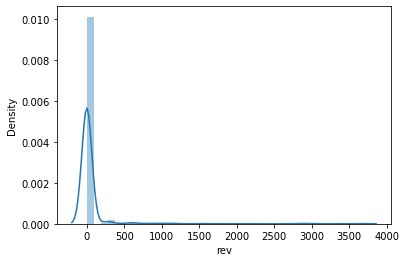

In [41]:
sns.distplot(a.rev)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


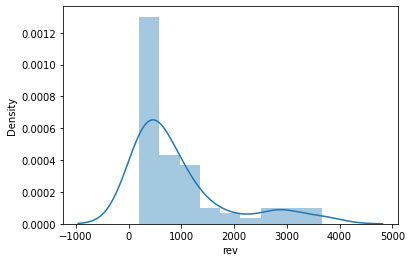

In [42]:
sns.distplot(a_was_paid.rev)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


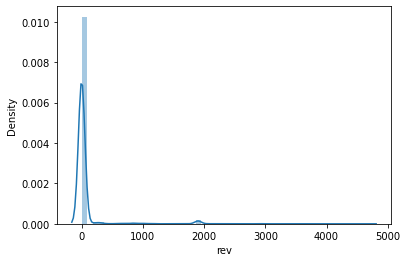

In [43]:
sns.distplot(b.rev)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


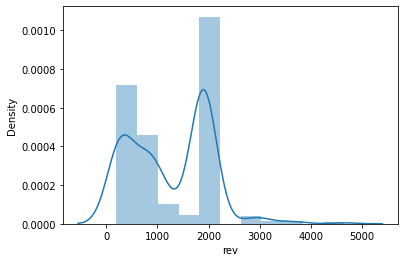

In [44]:
sns.distplot(b_was_paid.rev)

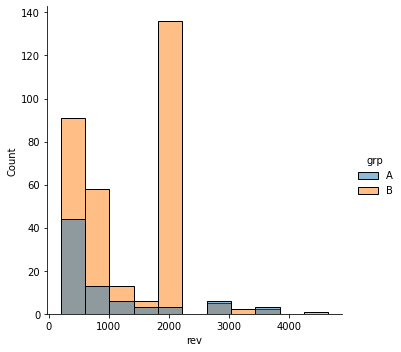

In [45]:
sns.displot(data=active_paid_not_zero, x="rev", hue="grp")

Ни одна из групп действительно не распределена нормально, подтвердили с помощью теста на нормальность от библиотеки пингвин и графиков

In [46]:
active_all.groupby('grp', as_index= False)\
          .agg({'rev': 'count'})

,grp,rev
0,A,1538
1,B,6803


Наблюдаем, что количество наблюдений в группах разное(а также распределение не нормальное), поэтому самым правильным решением на мой взгляд будет применение bootsrap. Посмотрим медианы у пользователей, которые совершили покупки.

In [47]:
active_paid_not_zero.groupby('grp', as_index= False).agg({'rev': np.median})

,grp,rev
0,A,585.0
1,B,1140.0


In [48]:
bootstrap((a_was_paid.rev, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=344.0, high=690.0), standard_error=69.52062126295262)

In [49]:
bootstrap((b_was_paid.rev, ), np.median, method='percentile')
# без указания аргумента method='percentile' по умолчанию стоит bca он возращает с поправкой на смещение и видимо из-за этого,
# выходит за пределы  [0-100] го процентиля, о чем указывала ошибка(если не method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=990.0, high=1900.0), standard_error=283.1792449087405)

Посмотрим тогда и в А группе без поправки на доверительный интервал, т.к. сравнивать число с поправкой и без не совсем корректно.

In [50]:
bootstrap((a_was_paid.rev, ), np.median, method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=398.0, high=690.0), standard_error=70.42068407010838)

Мы получили стат значимое различие между медианами, а именно, медианная покупка у группы B больше медианной покупкой группы A (Доверительные интервалы не перекрывают друг друга) Это может быть вызвано, что новая механиика оплаты, например предлагает дополнительные товары в момент оплаты, которые подходя пользователю и позволяет увеличиить средний чек.

Для большей наглядности посчитаем метрики и попробуем на их премере отследить был ли новый механизм оплаты лучше

##### Конверсия (conversion rate, CR) — отношение числа пользователей, которые выполнили какое-либо целевое действие к общему числу пользователей. В нашем случае это отношение количетсва оплативших клиентов к общему числу активных клиентов.

In [51]:
CR_a = a_was_paid.shape[0]/a.shape[0]

In [52]:
CR_a = round(CR_a, 4)
CR_a

0.0507

In [53]:
CR_b = b_was_paid.shape[0]/b.shape[0]

In [54]:
CR_b = round(CR_b, 4)
CR_b

0.0462

In [55]:
100 - 100 * CR_b / CR_a

8.875739644970409

CR группы B меньше на 8,9 % , посмотрим на остальные метрики, чтобы принять решение о эффективности нового метода оплаты

##### ARPPU (Average revenue per paying user) Средний доход на платящего пользователя (то есть клиента). Состоит из того, насколько часто пользователь покупает, и насколько большой средний чек покупки . В нашем случае это отношение общей суммы заказов к количеству и активных и оплативших


In [56]:
ARPPU_a = a_was_paid.rev.sum()/a_was_paid.shape[0]

In [57]:
ARPPU_a = round(ARPPU_a, )
ARPPU_a

934

In [58]:
ARPPU_b = b_was_paid.rev.sum()/b_was_paid.shape[0]

In [59]:
ARPPU_b = round(ARPPU_b, )
ARPPU_b

1258

In [60]:
ARPPU_b * 100 /ARPPU_a - 100

34.689507494646676

В группе B средний доход с привлеченного пользователя выше чем в группе A на 34.7%

##### ARPU (Average revenue per user) Cредний доход с привлечённого пользователя. В нашем случае это отношение общей суммы заказов на колитчество активных пользователей, включая тех кто не оплатил.

In [61]:
ARPU_a = a_was_paid.rev.sum()/a.shape[0]

In [62]:
ARPU_a = round(ARPU_a, )
ARPU_a

47

In [63]:
ARPU_b = b_was_paid.rev.sum()/b.shape[0]

In [64]:
ARPU_b = round(ARPU_b, )
ARPU_b

58

In [65]:
ARPU_b * 100 /ARPU_a - 100

23.40425531914893

Средний доход на привлеченного пользователя в группе B выше чем в группе A на 22.5 %

Теперь проведем тесты и определим насколько это статзначимые изминения.
Напишем функции которая будет считать CR, ARPU И ARPPU

In [66]:
def calculate_cr(df):
    total_users = len(df)
    paying_users = len(df[df['rev'] > 0])
    return paying_users / total_users

In [67]:
cr_a = calculate_cr(a)
cr_b = calculate_cr(b)

In [68]:
cr_a

0.05071521456436931

In [69]:
cr_b

0.046156107599588415

In [70]:
# Собираем все Conversion Rates в один массив
all_cr = np.concatenate((a['rev'], b['rev']), axis=None)

In [71]:
# Задаем параметры теста.
alpha = 0.05
n_iterations = 10000
sample_size = len(all_cr)

In [72]:
# Собираем распределение разницы в Conversion Rates
# Создаем пустой список differences, в который будут добавляться разницы между средними значениями 
# Conversion Rate для разных бутстрэп-выборок.
differences = [] 
for i in range(n_iterations):
    sample1 = np.random.choice(all_cr, size=sample_size, replace=True)
    sample2 = np.random.choice(all_cr, size=sample_size, replace=True)
    cr_diff = np.mean(sample1) - np.mean(sample2)
    differences.append(cr_diff)

In [73]:
observed_diff = cr_a - cr_b
observed_diff

0.004559106964780894

In [74]:
p_value = (np.abs(differences) >= np.abs(observed_diff)).mean()
#  np.abs(differences) мы берем абсолютное значение каждой разницы из списка differences.
# Это делается для того, чтобы учесть все направления изменений и сделать распределение симметричным.
# np.abs(observed_diff) Здесь мы берем абсолютное значение наблюдаемой разницы (observed_diff),
# которая была рассчитана на основе реальных данных.

# (np.abs(differences) >= np.abs(observed_diff)) создаем булев массив (массив из True и False), 
# где для каждой абсолютной разницы в списке differences мы проверяем, больше ли или равна эта 
# разница абсолютному значению наблюдаемой разницы.

# далее мы вызываем метод .mean() для булевого массива, который подсчитывает среднее значение. 
# Поскольку True преобразуется в 1, а False в 0 при вычислении среднего значения, 
# это позволяет нам определить долю случаев, когда абсолютная разница в бутстрэп-выборках была больше или равна 
# абсолютной наблюдаемой разнице.

# p_value, представляет собой долю случаев, когда абсолютная разница в бутстрэп-выборках была больше 
# или равна абсолютной наблюдаемой разнице. Это значение будет использоваться для 
# определения статистической значимости различия между метриками Conversion Rate для двух групп данных. 
# Если p_value меньше уровня значимости alpha, то мы будем считать различие статистически значимым.

In [75]:
# Проверяем статистическую значимость
if p_value < alpha:
    result = "статистически значимое изменение метрики CR"
else:
    result = "изменение метрики CR не является статистически значимым"

print(f"Conversion Rate A: {cr_a}")
print(f"Conversion Rate B: {cr_b}")
print(f"Наблюдаемая разница: {observed_diff}")
print(f"p-значение: {p_value}")
print(result)

Conversion Rate A: 0.05071521456436931
Conversion Rate B: 0.046156107599588415
Наблюдаемая разница: 0.004559106964780894
p-значение: 0.9991
изменение метрики CR не является статистически значимым


In [76]:
# Рассчитываем ARPU как отношение общей выручки к общему количеству активных пользователей
def calculate_arpu(df):
    total_revenue = df['rev'].sum()
    total_users = len(df)
    return total_revenue / total_users

In [77]:
arpu_a = calculate_arpu(a)
arpu_b = calculate_arpu(b)

In [78]:
arpu_a

47.34720416124838

In [79]:
arpu_b

58.05879810377775

In [80]:
# Собираем все ARPU в один массив
all_arpu = np.concatenate((a['rev'], b['rev']), axis=None)

In [81]:
# Задаем параметры бутстрэпа
n_iterations = 10000
sample_size = len(all_arpu)

In [82]:
# Собираем распределение разницы в ARPU
differences = []
for i in range(n_iterations):
    sample1 = np.random.choice(all_arpu, size=sample_size, replace=True)
    sample2 = np.random.choice(all_arpu, size=sample_size, replace=True)
    arpu_diff = np.mean(sample1) - np.mean(sample2)
    differences.append(arpu_diff)

In [83]:
observed_diff = arpu_a - arpu_b
observed_diff

-10.711593942529369

In [84]:
p_value = (np.abs(differences) >= np.abs(observed_diff)).mean()

In [85]:
#  Проверяем статистическую значимость
if p_value < alpha:
    result = "статистически значимое изменение метрики ARPU"
else:
    result = "изменение метрики ARPU не является статистически значимым"

print(f"ARPU A: {arpu_a}")
print(f"ARPU B: {arpu_b}")
print(f"Наблюдаемая разница: {observed_diff}")
print(f"p-значение: {p_value}")
print(result)

ARPU A: 47.34720416124838
ARPU B: 58.05879810377775
Наблюдаемая разница: -10.711593942529369
p-значение: 0.0295
статистически значимое изменение метрики ARPU


In [86]:
# Рассчитываем ARPPU как отношение общей выручки к общему количеству платящих и активных пользователей
def calculate_arppu(paying_users_df):
    total_revenue = paying_users_df['rev'].sum()
    total_paying_users = len(paying_users_df)
    return total_revenue / total_paying_users

In [87]:
arppu_a = calculate_arppu(a_was_paid)
arppu_b = calculate_arppu(b_was_paid)

In [88]:
arppu_a

933.5897435897435

In [89]:
arppu_b

1257.8789920382164

In [90]:
# Собираем все ARPPU в один массив
all_arppu = np.concatenate((a_was_paid['rev'], b_was_paid['rev']), axis=None)


In [91]:
# Задаем параметры бутстрэпа
n_iterations = 10000
sample_size = len(all_arppu)

# Собираем распределение разницы в ARPPU
differences = []
for i in range(n_iterations):
    sample1 = np.random.choice(all_arppu, size=sample_size, replace=True)
    sample2 = np.random.choice(all_arppu, size=sample_size, replace=True)
    arppu_diff = np.mean(sample1) - np.mean(sample2)
    differences.append(arppu_diff)

In [92]:
observed_diff = arppu_a - arppu_b
observed_diff

-324.2892484484729

In [93]:
p_value = (np.abs(differences) >= np.abs(observed_diff)).mean()


In [94]:
# Проверяем статистическую значимость
if p_value < alpha:
    result = "статистически значимое изменение метрики ARPPU"
else:
    result = "изменение метрики ARPPU не является статистически значимым"

print(f"ARPPU A: {arppu_a}")
print(f"ARPPU B: {arppu_b}")
print(f"Наблюдаемая разница: {observed_diff}")
print(f"p-значение: {p_value}")
print(result)

ARPPU A: 933.5897435897435
ARPPU B: 1257.8789920382164
Наблюдаемая разница: -324.2892484484729
p-значение: 0.0
статистически значимое изменение метрики ARPPU


### Выводы:

#### Я использовал три метрики ARPPU ARPU и CR и произвел оценку медианного чека.
- СR в группе B уменьшился на 8,9 % - изменение не является статистически значимым.
- ARPU в группе B вырос на 22.5 % - изменение является статистически значимым.
- ARPPU в группе B вырос на 34,7 % - изменение является статистически значимым.
- Также я провел тест на статистическую значимость изминения медианы с помощью Bootstrap, выявил, что статзначимость присутсвует, а значит медианный чек в группе B лучше чем в группе A (H0- медианный чек в двух группах одинаковый, H1- медианный чек в двух групах различается, в помощью бутстрепа мы отвергли нулевую гипотезу)
- На мой взгляд, стоит запустить новую механнику на всех пользователей, несмотря на уменьшение CR на первый взгляд это плохо, но результат получился не стат значимым, а изменение(увеличение) медианного чека и ARPU и ARPPU является статистически значимым выкатываем обновление нового механизма оплаты.
